<a href="https://colab.research.google.com/github/DL-WG/twitterScraper/blob/main/TwitterData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Downloading & Visualising Twitter data**


This notebook gives a brief demonstration of downloading and visualising Twitter data. The Twitter data used in this example is from the US President's official Twitter account in 2021, however you can swap out this to make your own queries involving different contraints including accounts, timescales, hashtags etc. For information on writing your own queries see [here](https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query). To run this script you will need your own API key, which you can do by signing up for a twitter developer account [here](https://https://developer.twitter.com/en/docs/twitter-api/getting-started/getting-access-to-the-twitter-api). 

After we download the Tweets from the API, the structure of the data in the response can be visualised and put into a pandas DataFrame. Finally we demo two visualisation methods; a word cloud using the text data of the tweets and a heatmap of tweet activity for the year. 

# Importing Libraries and setting Query parameters

Firstly, we import the libraries needed for downloading and visualising the data. The date needs to be converted into a different format to be read by the API (called [rfc3339](https://datatracker.ietf.org/doc/html/rfc3339)). The url is the endpoint to connect to, this notebook demos the search/all endpoint, but many more are available for downloading both historical and live data. You can see the full list of available endpoints [here](https://developer.twitter.com/en/docs/api-reference-index). Then the query is created. We can specify the fields we want returned (you can see [here](https://developer.twitter.com/en/docs/twitter-api/fields) which fields are available). And finally define the query body specifying which Tweets we want returned. For information on writing queries see [here](https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query).

NOTE: To run this script on your own machine you will need to apply for a Twitter developer account and generate an API key. Then replace the variable BARER_TOKEN with the key you have generated. 

In [2]:
import requests
import json
from datetime import datetime
!pip install rfc3339
import rfc3339
import pandas as pd
import re
import numpy as np
import string 
import re 
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import spacy 
from dateutil.parser import parse 
!pip install calplot
import calplot
import time



# REPLACE WITH YOUR OWN BEARER TOKEN
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAM2zMgEAAAAAjIFbBetAWCuAzaEL%2B5jSMyofgKE%3DwCGeSfjOYu91nXq0LJiygBheEegg7mU5dhecl2jD2IJIPiwbQI'

# SEARCH URL FOR FULL ARCHIVE SEARCH ENDPOINT
search_url = "https://api.twitter.com/2/tweets/search/all"


# CONVERTING DATES TO FORMAT NEEDED BY THE ENDPOINT
def get_rfc33339_date(date):
    dt = datetime.strptime(date, '%Y-%m-%d')
    return rfc3339.rfc3339(dt)

# YOU CAN MODIFY THESE DATES TO CREATE YOUR OWN TIME WINDOW
start_date = get_rfc33339_date('2021-01-01')
end_date = get_rfc33339_date('2021-12-31')


# DEFINING THE QUERY, IN LINE WITH TWITTERS QUERY SYNTAX
query = '(from:potus -is:retweet)'


# Optional params: start_time,end_time,since_id,until_id,max_results,next_token,
# expansions,tweet.fields,media.fields,poll.fields,place.fields,user.fields
# ADD / REMOVE AS NECESSARY
query_params = {'query': query,
                'start_time': start_date,
                'end_time': end_date,
                'tweet.fields': 'author_id,created_at,geo,id,text,public_metrics,referenced_tweets,reply_settings',
                'user.fields': 'description,id,name,username',
                'max_results': 500,
                'expansions': 'author_id'}


# Calling the API, Response Codes & Pagination

The functions below define the endpoint connection. connect_to_endpoint takes the url and query parameters, and bearer_oauth is used as an authentiction function to create the request headers. 

When we make a request to an API we check the HTTP status code of the response. 200 is a successful request (for a list of all status codes and their meanings see [here](https://developer.mozilla.org/en-US/docs/Web/HTTP/Status)). You can see in the code we check to see if the response has the error status code 429. A status code 429 means 'too many requests' - that the API request rate limit has been reached, and that no more requests can be made for a period of time. This is to protect from [DDOS attacks](https://www.cloudflare.com/en-gb/learning/ddos/what-is-a-ddos-attack/#:~:text=A%20distributed%20denial%2Dof%2Dservice%20(DDoS)), which can crash servers when users spam them with requests from applications. The code below checks if the response has code 429, and if it does then it waits and retrys later. 

In [3]:
# FUNCTION FOR CREATING THE REQUEST HEADERS INCLUDNG THE BEARER TOKEN
# this function is for authentication
def bearer_oauth(r):
    """
    Method required by bearer token authentication.
    """

    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2FullArchiveSearchPython"
    return r


# FUNCTION WHICH CONNECTS TO THE ENDPOINT AND HANDLES EXCEPTIONS
def connect_to_endpoint(url, params):
    response = requests.request("GET", search_url, auth=bearer_oauth, params=params)
    status_code = response.status_code

    # Twitter exception 429 is from too many reuqests to the API in a short time. 
    # If this happens just wait for a bit and then retry the request
    if status_code == 429:
        while status_code == 429:
            print('429 Twitter exception: too many requests. Waiting & retrying')
            time.sleep(10)
            response = requests.request("GET", search_url, auth=bearer_oauth, params=params)
            status_code = response.status_code
            print(status_code)

    elif status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

Now call this function, query the endpoint and print the [JSON](https://www.json.org/json-en.html) response. The response body contains Tweets in a 'data' tag, which each contain Tweet IDs, author IDs, time published and metrics on likes, quotes, replies and retweets. There is also a 'meta' tag at the end of the response, which contains information about the data contained in the 'data' tag. The 'meta' tag sometimes contains a next_token.

---



In [4]:
json_response = connect_to_endpoint(search_url, query_params)
print(json.dumps(json_response, indent=4, sort_keys=True))

{
    "data": [
        {
            "author_id": "1349149096909668363",
            "created_at": "2021-12-30T16:51:17.000Z",
            "id": "1476596766409736195",
            "public_metrics": {
                "like_count": 72331,
                "quote_count": 2367,
                "reply_count": 15110,
                "retweet_count": 10012
            },
            "reply_settings": "everyone",
            "text": "When I came into office, our economy was in crisis. \n \nBut over the last 11 months, we\u2019ve added nearly 6 million jobs.\n \nThat\u2019s the largest increase in recorded history."
        },
        {
            "author_id": "1349149096909668363",
            "created_at": "2021-12-30T15:43:08.000Z",
            "id": "1476579613799337987",
            "public_metrics": {
                "like_count": 37572,
                "quote_count": 1093,
                "reply_count": 5287,
                "retweet_count": 5766
            },
            "reply_settin

The Twitter API sets a limit of 500 tweets which can be included in a response like this. However, sometimes our queries will need to return thousands or millions of tweets. In this case, the response will include a 'next token'. 

A next token is a merker to say that there is more data to collect, and that we have collected up to a certain point. For example, in the request we just made we asked for the first 500 results, as outlined in the 'max results' field. In the response meta tag, we were given a next token which is unique to this query. Simply, the next token says:

"You have made this query before and retrieved the firt 500 results, if you make this query again and include this token, we will transfer results starting at the 501st entry".

Therefore, the code below iteratively modifies the query to contain the new next token, and then recalls the API using this token to get the next page of the data. This is called [pagination](https://nordicapis.com/everything-you-need-to-know-about-api-pagination/).


In [5]:
tweets = json_response['data']

try:
  # try to get next token from response
  next_token = json_response['meta']['next_token']
except KeyError:
  next_token = None

while next_token is not None:
  # modify query to contain next token
  nt_query_params = {'query': query,
                'start_time': start_date,
                'end_time': end_date,
                'tweet.fields': 'author_id,created_at,geo,id,text,public_metrics,referenced_tweets,reply_settings',
                'user.fields': 'description,id,name,username',
                'max_results': 500,
                'expansions': 'author_id',
                'next_token': next_token}

  # reconnect to endpoint & save results
  nt_json_response = connect_to_endpoint(search_url, nt_query_params)
  nt_tweets = nt_json_response['data']
  print('found {} new results'.format(len(nt_tweets)))
  tweets += nt_tweets
  print('total {} results'.format(len(tweets)))

  # see if there is a new next token
  try:
    next_token = nt_json_response['meta']['next_token']
  except KeyError:
    next_token = None


found 500 new results
total 1000 results
found 500 new results
total 1500 results
429 Twitter exception: too many requests. Waiting & retrying
200
found 500 new results
total 2000 results
429 Twitter exception: too many requests. Waiting & retrying
200
found 118 new results
total 2118 results


Next tokens allow successive calls to APIs to recieve pages of data. Often queries will return thousands or even millions of results, and transferring this much data is not secure.

# Data Preprocessing

Pandas is useful for conveting data into a DataFrame for analysis. The only thing that is slightly fiddly is the nested data in the 'public_metrics' tag (See printed response above). The rest of the JSON can be read into a DataFrame really easily. We convert the 'public_metrics' tag separately to a DataFrame and append it. Also convert the 'created_at' time back to a python friendly format.


We can now start to make our own variables, like 'sum_reactions' which I have defined to be the sum of all the likes, retweets, quotes & replies. We will use this in the analysis. 


In [6]:
# convert tweets to a pandas Dataframe with an Index
tweets_df = pd.DataFrame(data=tweets)
tweets_df.index = tweets_df['id']

# The tag 'public_metrics' is nested, convert nested data to a new DataFrame and append to the original 
public_metrics = [x['public_metrics'] for x in tweets]
public_metrics_df = pd.DataFrame(data=public_metrics, index=tweets_df['id'])
tweets_df = tweets_df.merge(public_metrics_df, on=public_metrics_df.index)

# convert the date back to a python datetime and drop unwanted columns
tweets_df['dtime'] = tweets_df['created_at'].apply(lambda x: parse(x))
tweets_df = tweets_df.drop(columns=['public_metrics', 'key_0', 'created_at'])

# create a new column which is the sum of the retweets, replies, likes and quotes - this is the total reactions for this tweet
tweets_df['sum_reactions'] = tweets_df['retweet_count'] + tweets_df['reply_count'] + tweets_df['like_count'] + tweets_df['quote_count']

# show final dataframe
tweets_df.head()

,author_id,text,reply_settings,id,referenced_tweets,retweet_count,reply_count,like_count,quote_count,dtime,sum_reactions
0,1349149096909668363,"When I came into office, our economy was in cr...",everyone,1476596766409736195,NaN,10012,15110,72331,2367,2021-12-30 16:51:17+00:00,99820
1,1349149096909668363,"Last year at this time, there were 823,000 Ame...",everyone,1476579613799337987,NaN,5766,5287,37572,1093,2021-12-30 15:43:08+00:00,49718
2,1349149096909668363,"Today, I committed $137 million to expanding t...",everyone,1476387686848073738,NaN,2612,3476,15394,410,2021-12-30 03:00:29+00:00,21892
3,1349149096909668363,We’re ending 2021 with what one analyst descri...,everyone,1476311650424832000,NaN,8936,28492,59167,6417,2021-12-29 21:58:20+00:00,103012
4,1349149096909668363,The economy I inherited nearly a year ago wasn...,everyone,1476253000301699076,NaN,4615,4551,26927,521,2021-12-29 18:05:17+00:00,36614


In [7]:
print('Number of Users=>',len(tweets_df['author_id'].unique()))
print('Number of Tweets=>',len(tweets_df['id'].unique()))
print('Total retweets : {}, replies : {}, likes : {}, quotes : {}'.format(tweets_df['retweet_count'].sum(), tweets_df['reply_count'].sum(), tweets_df['like_count'].sum(), tweets_df['quote_count'].sum(),))


Number of Users=> 1
Number of Tweets=> 2118
Total retweets : 10537314, replies : 6398955, likes : 85885043, quotes : 1414522


We now have our downloaded Tweets for our query stored nicely and cleanly in a DataFrame with the text and the tweet metrics. We have successfully downloaded Twitter data! Now we can start to perform some analysis on this data. We will focus first on the analysis of the text by creating wordclouds.

Word clouds work in a simple way: the more a specific word appears in a source of textual data, the bigger and bolder it appears in the word cloud. This is useful for visualising themes or topics which are mentioned commonly in the text. In order to create a wordcloud we need to clean the text data. This is because language can be messy, and there are often multiple different words / ways for saying the same thing. Therefore, we need to clean / reduce our text data so that we only include the key words / terms in the text. 

This is just preprocessing for the text data before we use algorithms on it. Text data is noisy and so this reduces noise (unimportant words or phrases) and maximises the signal (topics / contexts). The preprocessing is done in a few steps, you can read more about these steps [here](https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html#:~:text=Expanding%20Contractions&text=These%20shortened%20versions%20or%20contractions,I%20would%20to%20I'd.):

1. Expanding contractions: Contractions are the shortened versions of words like don’t for do not and how’ll for how will. These are used to reduce the speaking and writing time of words. We need to expand these contractions for a better analysis. 

2. Remove hyperlinks: Hyperlinks in the text are useless for linguistic analysis, but may be useful metadata. 

3. Clean text: Remove punctuation, lower case the text and remove extra spaces.


In [8]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions
tweets_df['text']=tweets_df['text'].apply(lambda x:expand_contractions(x))

# remove hyperlinks from text (Note: You may want to do something else with these!)
tweets_df['cleaned'] = tweets_df['text'].apply(lambda x: re.sub(r'http\S+', '', x))


# Lowercase the text & remove digits
tweets_df['cleaned']=tweets_df['cleaned'].apply(lambda x: x.lower())
# tweets_df['cleaned']=tweets_df['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))

# remove punctuation 
tweets_df['cleaned']=tweets_df['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

# Removing extra spaces
tweets_df['cleaned']=tweets_df['cleaned'].apply(lambda x: re.sub(' +',' ',x))


pd.set_option('display.max_colwidth', None)
tweets_df['cleaned'].head()

0                                                                                                                     when i came into office our economy was in crisis \n \nbut over the last 11 months we’ve added nearly 6 million jobs\n \nthat’s the largest increase in recorded history
1                                                                                                                     last year at this time there were 823000 americans filing new jobless claims each week\n \nthis last week that number was less than 200000 \n \nthat’s historic progress
2                                                                                                                                                      today i committed 137 million to expanding the production of covid19 athome tests using our military authority in order to meet demand 
3                                                                                                                   we’re ending 2021 with 

# Data Visualisation

We have now cleaned our text data for analysis. Now we can implement a Natural Language Processing model on our text data to extract themes and topics. We can do this using [SpaCy](https://spacy.io/)'s NLP model. Using this, we can lemmatise our text into tokens. Tokens are the key, base form words that are in the text. Lemmatising looks for the base form of tokens in the text by considering the word and its use (part-of-speech) in the sentence. [Lemmatizing](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) reduces the text further to its key tokens.

In [9]:
# Load model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatise & remove stopwords (I, this, is, etc)
tweets_df['lemmatized']=tweets_df['cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

pd.set_option('display.max_colwidth', None)
print(tweets_df['lemmatized'])

0                                                                   come office economy crisis \n \n 11 month add nearly 6 million job \n \n large increase record history
1                                                                  year time 823000 americans file new jobless claim week \n \n week number 200000 \n \n historic progress
2                                                                      today commit 137 million expand production covid19 athome test military authority order meet demand
3                                                                 end 2021 analyst describe strong firstyear economic track record president 50 year \n \n let progress go
4       economy inherit nearly year ago crisis — work work people \n \n pass american rescue plan bipartisan infrastructure law help change \n \n rebuild economy middle —
                                                                                       ...                                                       

# Word Clouds

You can see from printing the head of the lemmatised column that this is the text reduced down to its key words and phrases. Now we have our lemmatized tokens for each tweet, we can use this to plot our [wordcloud](https://amueller.github.io/word_cloud/) showing the most frequently mentioned tokens / topics. To do this, we combine the lemmatised tweet text into one string, then simply use the Wordcloud library to visualise our dataset. 

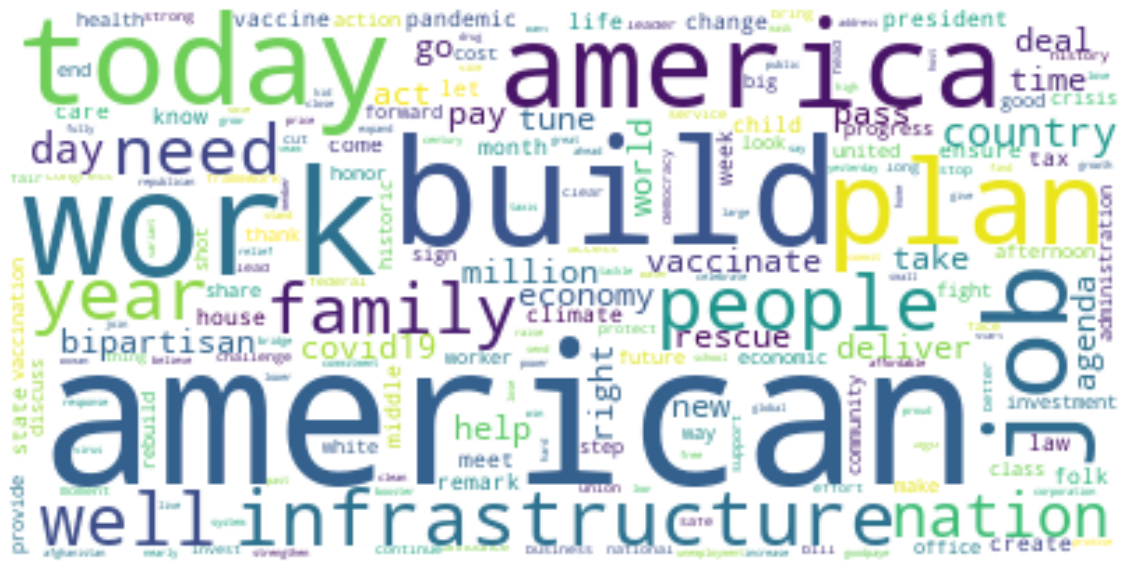

In [14]:
text = " ".join(val for val in tweets_df.lemmatized)
word_cloud = WordCloud(width=400, height=200 , collocations = False, background_color = 'white').generate(text)

fig, ax = plt.subplots()
ax.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.rcParams["figure.figsize"] = (20,40)
plt.show()

Wordclouds are a simple, useful way to visualise a text dataset. We will now go over one other form of visualisation of the numerical data. When we download the Tweets we are given other metrics / data, such as Retweet, like, quote count, which we can visualise too. Before, we created a variable for each tweet called sum_reactions - the total number of reactions for that tweet. We will now plot this value as a heatmap for each day.

# Heatmaps

For our final visualisation we are going to create a heatmap. Heatmaps are a really usefulb way to visualise acivity over time in a dataset. For this, we are not going to use our text data at all, in stead, the data we are going to plot is the variable which we created earlier, the 'sum_reactions' column which we created as the sum of the likes, quotes, retweets and replies. 


The [heatmap](https://thiago-bernardes-carvalho.medium.com/calendar-heatmaps-with-pythons-calplot-b4dec29ee805) function which we are going to use takes in a pandas Series indexed with a dateime object. Initially, this may seem difficult to implement, however, pandas makes this a lot easier . In one line of code, we can group and resmaple our dataset much like you can in SQL. We can resmaple our dataset and group tweets based on the day they were published, and sum the attribute sum_reactions for this day. In pandas this is just one line of code. 

In [11]:
reactions_by_day = tweets_df.resample('d', on='dtime')['sum_reactions'].sum()
# reactions_by_day.head()

This gives us an indexed Series with the summed total number of reactions for all tweets for each day. This can now easily be plotted using the calplot library in python

Day with most reactions: dtime
2021-01-21 00:00:00+00:00    2225728
Freq: D, Name: sum_reactions, dtype: int64


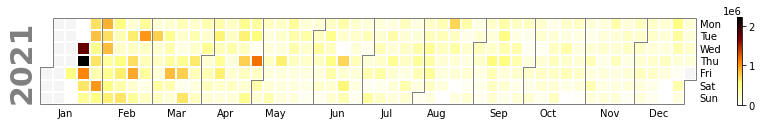

In [17]:
calplot.calplot(reactions_by_day, cmap='afmhot_r')
print("Day with most reactions: {}".format(reactions_by_day.nlargest(1)))

# Bonus: Sentiment Analysis

As an extra part of this lecture, I have included a little extra bit of analysis which you may find useful. The following piece of code implements a sentimental analysis on the Tweets. Sentiment analysis is the process of computationally identifying and categorizing opinions expressed in a piece of text. It is the process of converting qualitative textual data into a quantitative numerical metric. The text is given a numerical value, generally between -1 and 1, that represents the overall emotional positivity expressed in the text. For example, a very positive and happy piece of text would have a sentiment analysis value of close to one, and a very negative and sad piece of text would have a value close to -1. A neutral piece of text would have a value of 0. You can read more about sentiment analysis [here](https://towardsdatascience.com/sentiment-analysis-concept-analysis-and-applications-6c94d6f58c17) 

We can implement this easily on our lemmatised text data using the [Textblob](https://textblob.readthedocs.io/en/dev/quickstart.html) library in python. After calculating sentiment polarity values for the lemmatised tweet tezxt data, we can plot the most positive and negative tweets in our dataset. 

In [13]:
# Calculate polarity from text
tweets_df['polarity']=tweets_df['lemmatized'].apply(lambda x:TextBlob(x).sentiment.polarity)

# Print the three most 'positive' tweets 
print("3 Random Tweets with Highest Polarity:")
for index,review in enumerate(tweets_df.iloc[tweets_df['polarity'].sort_values(ascending=False)[:3].index]['text']):
  print('Tweet {}:\n'.format(index+1),review)

# Print the three most 'negative' tweets
print("3 Random Tweets with Lowest Polarity:")
for index,review in enumerate(tweets_df.iloc[tweets_df['polarity'].sort_values(ascending=True)[:3].index]['text']):
  print('Tweet {}:\n'.format(index+1),review)

3 Random Tweets with Highest Polarity:
Tweet 1:
 On this anniversary of the Freedom Rides, we honor those who courageously took a stand against segregation and injustice sixty years ago. Their message of bravery, hope, and unity in diversity continues to inspire us to build a more perfect union for all.
Tweet 2:
 Today was a perfect reminder of what our families need so our economy can thrive. We can’t compete in the world if millions of Americans can’t be part of the workforce because they can’t afford the cost of child care. My Build Back Better Agenda will change that. https://t.co/Zmt94qtwtW
Tweet 3:
 We’ve made incredible progress in the fight against COVID-19, but we need everyone across the country to pull together to get us over the finish line. Get vaccinated — and encourage your friends and family to get protected as well.

We can do this.
3 Random Tweets with Lowest Polarity:
Tweet 1:
 Millions of folks across the country have diabetes, sometimes paying around $1,000 a month

This is an interesting thing to look at, but is very much the tip of the iceburg when it comes to what you can  do with sentiment analysis in terms of data anlysis and visualisation. 

Thanks for reading! 